In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
%matplotlib inline

# Download ForestCoverType dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
dataset_name = 'forest-cover-type'
tmp_out = Path('./data/'+dataset_name+'.gz')
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [3]:
# check if using cuda
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f'device: {device}')

device: cuda


In [4]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, tmp_out.as_posix())
    with gzip.open(tmp_out, 'rb') as f_in:
        with open(out, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

# Load data and split
Same split as in original paper

In [5]:
target = "Covertype"

bool_columns = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

int_columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    int_columns + bool_columns + [target])

In [6]:
train = pd.read_csv(out, header=None, names=feature_columns)

n_total = len(train)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [7]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

# Define categorical features for categorical embeddings

In [8]:
# This is a generic pipeline but actually no categorical features are available for this dataset

unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Network parameters

In [9]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/home/paritosh/workspace/tabnet/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Training

In [10]:
if os.getenv("CI", False):
# Take only a subsample to run CI
    X_train = train[features].values[train_indices][:1000,:]
    y_train = train[target].values[train_indices][:1000]
else:
    X_train = train[features].values[train_indices]
    y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [11]:
max_epochs = 100 if not os.getenv("CI", False) else 2
# max_epochs = 10 if not os.getenv("CI", False) else 2

In [12]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256,
    augmentations=aug
) 

epoch 0  | loss: 1.27357 | train_accuracy: 0.08309 | valid_accuracy: 0.08263 |  0:00:05s
epoch 1  | loss: 0.79606 | train_accuracy: 0.04098 | valid_accuracy: 0.04054 |  0:00:10s
epoch 2  | loss: 0.71655 | train_accuracy: 0.03655 | valid_accuracy: 0.0364  |  0:00:16s
epoch 3  | loss: 0.69805 | train_accuracy: 0.14264 | valid_accuracy: 0.14148 |  0:00:21s
epoch 4  | loss: 0.68321 | train_accuracy: 0.03844 | valid_accuracy: 0.03845 |  0:00:26s
epoch 5  | loss: 0.67213 | train_accuracy: 0.11338 | valid_accuracy: 0.11261 |  0:00:32s
epoch 6  | loss: 0.66862 | train_accuracy: 0.13856 | valid_accuracy: 0.13806 |  0:00:37s
epoch 7  | loss: 0.65565 | train_accuracy: 0.14156 | valid_accuracy: 0.14015 |  0:00:42s
epoch 8  | loss: 0.65136 | train_accuracy: 0.17754 | valid_accuracy: 0.17645 |  0:00:48s
epoch 9  | loss: 0.64366 | train_accuracy: 0.25853 | valid_accuracy: 0.26021 |  0:00:53s
epoch 10 | loss: 0.6342  | train_accuracy: 0.30954 | valid_accuracy: 0.3112  |  0:00:58s
epoch 11 | loss: 0.63

/home/paritosh/workspace/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


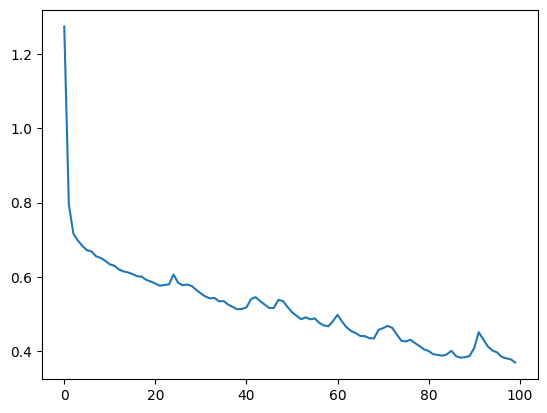

In [13]:
# plot losses
plt.plot(clf.history['loss'])

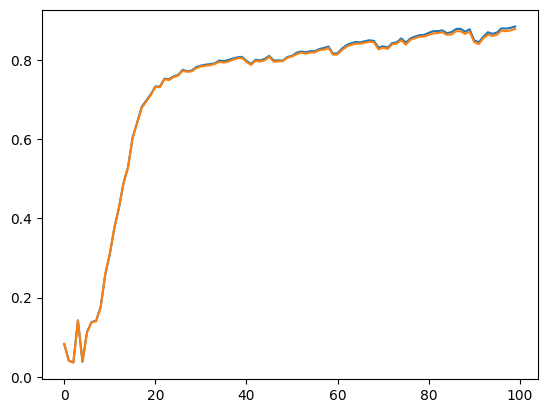

In [14]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

In [15]:
# from sklearn.utils import shuffle
# from torch.utils.data import TensorDataset, DataLoader

# # Set the number of samples per class
# samples_per_class = 500

# # Get the unique classes from the training target
# unique_classes = np.unique(y_train)

# # Create a list to store the selected indices for each class
# selected_indices = []

# # Iterate over each unique class
# for class_label in unique_classes:
#     # Find the indices of samples belonging to the current class
#     class_indices = np.where(y_train == class_label)[0]
    
#     # Shuffle the indices to ensure randomness
#     shuffled_indices = shuffle(class_indices, random_state=42)
    
#     # Select the first 'samples_per_class' indices for the current class
#     selected_class_indices = shuffled_indices[:samples_per_class]
    
#     # Append the selected indices to the list
#     selected_indices.extend(selected_class_indices)

# # Convert the selected indices to a numpy array
# selected_indices = np.array(selected_indices)

# # Get the features and target for the selected samples
# X_train_balanced = X_train[selected_indices]
# y_train_balanced = y_train[selected_indices]

# # Create a PyTorch dataset and data loader for the balanced training set
# train_balanced_dataset = TensorDataset(torch.from_numpy(X_train_balanced).float(), torch.from_numpy(y_train_balanced).long())
# train_balanced_loader = DataLoader(train_balanced_dataset, batch_size=128, shuffle=False)

In [16]:
# # Save the trained model
# model_path = "tabnet_model"
# clf.save_model(model_path)

# # Load the saved model
# loaded_clf = TabNetClassifier(
#     n_d=64, n_a=64, n_steps=5,
#     gamma=1.5, n_independent=2, n_shared=2,
#     cat_idxs=cat_idxs,
#     cat_dims=cat_dims,
#     cat_emb_dim=1,
#     lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
#     optimizer_fn=torch.optim.Adam,
#     optimizer_params=dict(lr=2e-2),
#     scheduler_params={"gamma": 0.95, "step_size": 20},
#     scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
# )
# loaded_clf.load_model(model_path+".zip")

# # Extract embeddings for the balanced training set using the loaded model
# train_embeddings = []
# for data in train_balanced_loader:
#     data = data[0]  # Assuming data is a tuple (features, target)
#     _, embedded = loaded_clf.explain(data)
#     train_embeddings.append(embedded)

# train_embeddings = np.vstack(train_embeddings)

In [17]:
# # import torch
# from torch.utils.data import TensorDataset, DataLoader
# from sklearn.utils import shuffle

# # Set the number of samples per class
# samples_per_class = 500

# # Get the unique classes from the training target
# unique_classes = np.unique(y_train)

# # Create a list to store the selected indices for each class
# selected_indices = []

# # Iterate over each unique class
# for class_label in unique_classes:
#     # Find the indices of samples belonging to the current class
#     class_indices = np.where(y_train == class_label)[0]
    
#     # Shuffle the indices to ensure randomness
#     shuffled_indices = shuffle(class_indices, random_state=42)
    
#     # Select the first 'samples_per_class' indices for the current class
#     selected_class_indices = shuffled_indices[:samples_per_class]
    
#     # Append the selected indices to the list
#     selected_indices.extend(selected_class_indices)

# # Convert the selected indices to a numpy array
# selected_indices = np.array(selected_indices)

# # Get the features and target for the selected samples
# X_train_balanced = X_train[selected_indices]
# y_train_balanced = y_train[selected_indices]

# # Save the trained model
# model_path = "tabnet_model"
# clf.save_model(model_path)

# # Load the saved model
# loaded_clf = TabNetClassifier(
#     n_d=64, n_a=64, n_steps=5,
#     gamma=1.5, n_independent=2, n_shared=2,
#     cat_idxs=cat_idxs,
#     cat_dims=cat_dims,
#     cat_emb_dim=1,
#     lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
#     optimizer_fn=torch.optim.Adam,
#     optimizer_params=dict(lr=2e-2),
#     scheduler_params={"gamma": 0.95, "step_size": 20},
#     scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
# )
# loaded_clf.load_model(model_path+".zip")

# # Extract embeddings for the balanced training set using the loaded model
# probs, train_embeddings = loaded_clf.predict_proba(X_train_balanced)

# print("Shape of train_embeddings:", train_embeddings.shape)

In [18]:
# print(train_embeddings.shape)

### Predictions


In [19]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR forest-cover-type : 0.878260196079697
FINAL TEST SCORE FOR forest-cover-type : 0.8811132242713183


In [20]:
# or you can simply use the predict method

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.8811132242713183


# Save and load Model

In [21]:
# save state dict
saved_filename = clf.save_model('test_model')

Successfully saved model at test_model.zip


In [22]:
# define new model and load save parameters
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filename)

/home/paritosh/workspace/tabnet/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [23]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.8811132242713183


In [24]:
assert(test_acc == loaded_test_acc)

# Global explainability : feat importance summing to 1

In [25]:
clf.feature_importances_

array([1.38007383e-01, 5.40572371e-02, 2.08481290e-05, 3.04097697e-02,
       4.66621519e-02, 5.57399268e-02, 2.18767870e-02, 3.26327055e-02,
       0.00000000e+00, 9.47937260e-03, 6.54386397e-02, 2.31019880e-02,
       1.63795704e-02, 5.52711972e-02, 2.18987404e-05, 7.51643102e-03,
       1.72224614e-04, 3.52424343e-03, 7.82578043e-03, 3.29549723e-03,
       2.23850224e-02, 1.13340070e-02, 6.85158329e-04, 5.21424728e-03,
       1.37747461e-03, 8.14274704e-02, 1.63934238e-02, 7.89559229e-03,
       1.38438038e-03, 6.21978586e-03, 8.96083329e-05, 1.35931808e-02,
       1.60578096e-02, 1.54808904e-04, 1.73355280e-02, 2.51950511e-02,
       1.75935974e-02, 1.05326157e-02, 6.58263802e-03, 5.28765037e-04,
       1.39080316e-03, 2.88413796e-03, 1.96212968e-02, 5.26950615e-03,
       3.31341900e-03, 4.12516919e-04, 1.77276570e-02, 2.70825486e-03,
       1.47649604e-04, 2.12178995e-02, 2.61320131e-04, 2.07515766e-02,
       2.33587293e-02, 4.75214155e-02])

# Local explainability and masks

In [26]:
explain_matrix, masks = clf.explain(X_test)

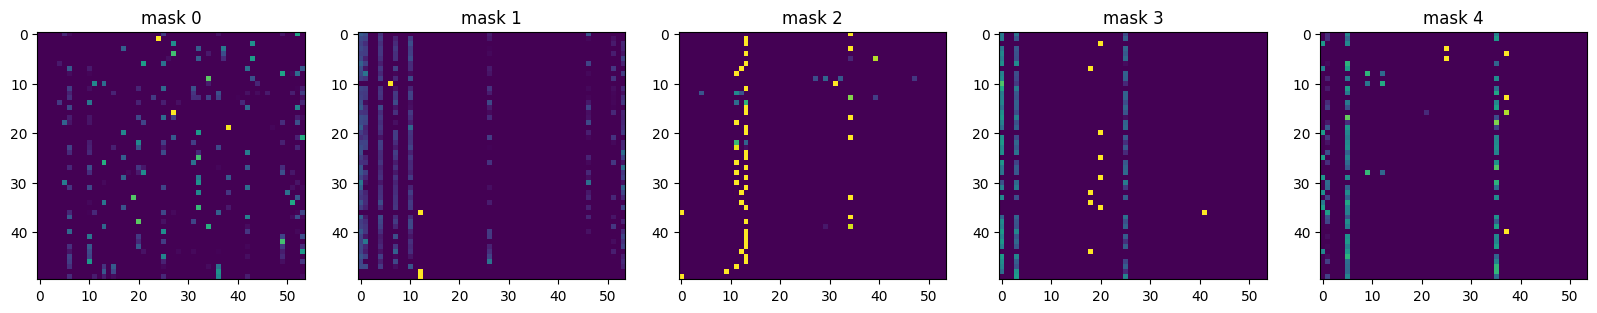

In [27]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# XGB

In [28]:
n_estimators = 1000 if not os.getenv("CI", False) else 20

In [30]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=n_estimators,
    verbosity=0,
    silent=None,
    objective="multi:softmax",
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=40,
            verbose=10)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6], got [1 2 3 4 5 6 7]

In [ ]:
preds_valid = np.array(clf_xgb.predict_proba(X_valid, ))
valid_acc = accuracy_score(y_pred=np.argmax(preds_valid, axis=1) + 1, y_true=y_valid)
print(valid_acc)

preds_test = np.array(clf_xgb.predict_proba(X_test))
test_acc = accuracy_score(y_pred=np.argmax(preds_test, axis=1) + 1, y_true=y_test)
print(test_acc)